## Migrating from Spark to BigQuery via Dataproc -- Part 1

* [Part 1](01_spark.ipynb): The original Spark code, now running on Dataproc (lift-and-shift).
* [Part 2](02_gcs.ipynb): Replace HDFS by Google Cloud Storage. This enables job-specific-clusters. (cloud-native)
* [Part 3](03_automate.ipynb): Automate everything, so that we can run in a job-specific cluster. (cloud-optimized)
* [Part 4](04_bigquery.ipynb): Load CSV into BigQuery, use BigQuery. (modernize)
* [Part 5](05_functions.ipynb): Using Cloud Functions, launch analysis every time there is a new file in the bucket. (serverless)


### Copy data to HDFS

The Spark code in this notebook is based loosely on the [code](https://github.com/dipanjanS/data_science_for_all/blob/master/tds_spark_sql_intro/Working%20with%20SQL%20at%20Scale%20-%20Spark%20SQL%20Tutorial.ipynb) accompanying [this post](https://opensource.com/article/19/3/apache-spark-and-dataframes-tutorial) by Dipanjan Sarkar. I am using it to illustrate migrating a Spark analytics workload to BigQuery via Dataproc.

The data itself comes from the 1999 KDD competition. Let's grab 10% of the data to use as an illustration.

In [1]:
!wget https://storage.googleapis.com/cloud-training/dataengineering/lab_assets/sparklab/kddcup.data_10_percent.gz

--2022-12-24 02:18:30--  https://storage.googleapis.com/cloud-training/dataengineering/lab_assets/sparklab/kddcup.data_10_percent.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

kddcup.data_10_perc 100%[===================>]   2.04M  --.-KB/s    in 0.02s   

2022-12-24 02:18:30 (114 MB/s) - ‘kddcup.data_10_percent.gz’ saved [2144903/2144903]



In [2]:
!hadoop fs -put kddcup* /

In [3]:
!hadoop fs -ls /

Found 4 items
-rw-r--r--   2 root hadoop    2144903 2022-12-24 02:18 /kddcup.data_10_percent.gz
drwxrwxrwt   - hdfs hadoop          0 2022-12-24 02:12 /tmp
drwxrwxrwt   - hdfs hadoop          0 2022-12-24 02:12 /user
drwxrwxrwt   - hdfs hadoop          0 2022-12-24 02:12 /var


### Reading in data

The data are CSV files. In Spark, these can be read using textFile and splitting rows on commas.

In [4]:
from pyspark.sql import SparkSession, SQLContext, Row

spark = SparkSession.builder.appName("kdd").getOrCreate()
sc = spark.sparkContext
data_file = "hdfs:///kddcup.data_10_percent.gz"
raw_rdd = sc.textFile(data_file).cache()
raw_rdd.take(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/24 02:18:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/12/24 02:18:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/12/24 02:18:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/12/24 02:18:40 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.']

In [5]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]), 
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    num_compromised=int(r[12]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    label=r[-1]
    )
)
parsed_rdd.take(5)

[Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=181, dst_bytes=5450, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=239, dst_bytes=486, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=235, dst_bytes=1337, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=219, dst_bytes=1337, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp',

### Spark analysis

One way to analyze data in Spark is to call methods on a dataframe.

In [6]:
sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(parsed_rdd)
connections_by_protocol = df.groupBy('protocol_type').count().orderBy('count', ascending=False)
connections_by_protocol.show()

+-------------+------+
|protocol_type| count|
+-------------+------+
|         icmp|283602|
|          tcp|190065|
|          udp| 20354|
+-------------+------+



Another way is to use Spark SQL

In [7]:
df.registerTempTable("connections")
attack_stats = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
attack_stats.show()

+-------------+---------+----------+--------------+--------------+-------------+-------------------+-----------------+--------------------+-------------------+------------------+
|protocol_type|    state|total_freq|mean_src_bytes|mean_dst_bytes|mean_duration|total_failed_logins|total_compromised|total_file_creations|total_root_attempts|total_root_acceses|
+-------------+---------+----------+--------------+--------------+-------------+-------------------+-----------------+--------------------+-------------------+------------------+
|         icmp|   attack|    282314|        932.14|           0.0|          0.0|                  0|                0|                   0|                0.0|                 0|
|          tcp|   attack|    113252|       9880.38|        881.41|        23.19|                 57|             2269|                  76|                1.0|               152|
|          tcp|no attack|     76813|       1439.31|       4263.97|        11.08|                 18|     

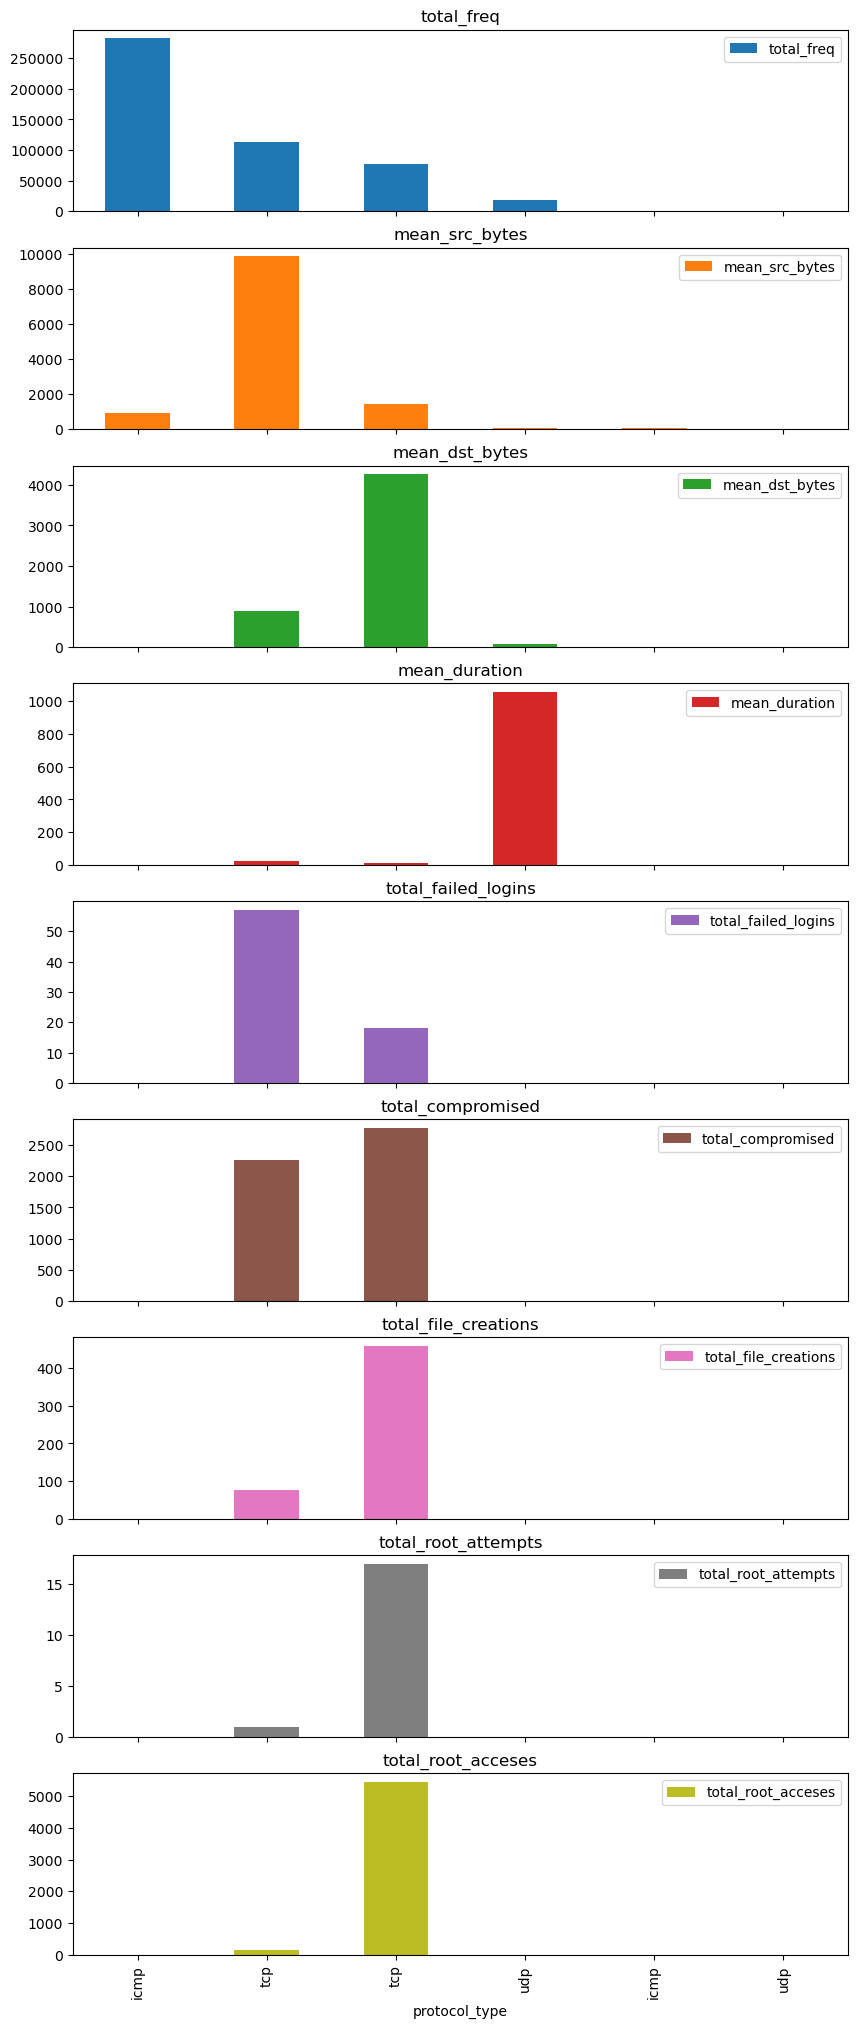

In [8]:
%matplotlib inline
ax = attack_stats.toPandas().plot.bar(x='protocol_type', subplots=True, figsize=(10,25))

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.